In [154]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.pylab as pp
from numpy.fft import fftshift, fft2, fftfreq
from scipy.ndimage import map_coordinates
from scipy.signal import windows
from matplotlib.colors import LogNorm
import os

In [155]:
features_dir = r"C:\Users\ariel\PycharmProjects\MLDM_Project\data\multi_trajectories\cropped\22_30\cut_1"

frames = []

filenames = sorted(os.listdir(features_dir))
print(filenames) # Checking they've been imported in the correct order
for filename in filenames:
    if filename.endswith(".jpg"):
        img = Image.open(os.path.join(features_dir, filename))
        width, height = img.size
        img = img.resize((224, 224))
        img = img.convert('L')
        img = np.asarray(img)
        img = img / 255
        frames.append(img)

print(np.shape(frames[0]))
data=np.array(frames)
time_step = 0.1  # Time step between measurements

['01.jpg', '02.jpg', '03.jpg', '04.jpg', '05.jpg', '06.jpg', '07.jpg', '08.jpg', '09.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg']
(224, 224)


C:\Users\ariel\AppData\Local\Temp\ipykernel_2216\3063009291.py:23: RuntimeWarning: Mean of empty slice
  mpow = np.nanmean(pol_psd, 0)


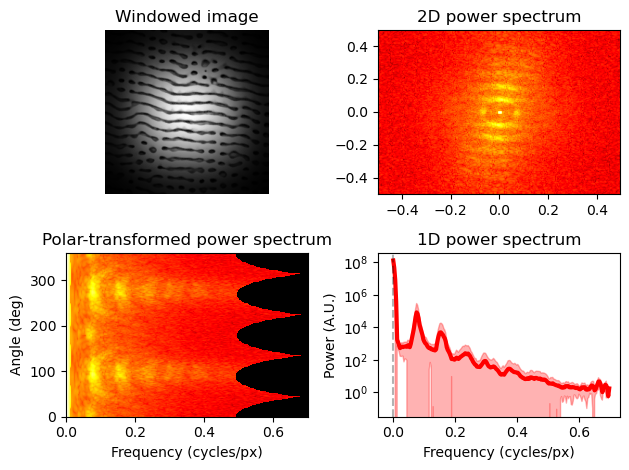

In [156]:
def batch_compute_2d_psd(frames, winfun=windows.hamming):
    spectra_over_time = np.zeros((frames.shape[0], frames.shape[1]))
    
    for i, frame in enumerate(frames):
        # Apply window function
        win = make2DWindow(frame.shape, winfun)
        f2 = fftshift(fft2(frame * win))
        psd = np.abs(f2)**2
        pol_psd = polar_transform(psd, centre=(frame.shape[0]//2, frame.shape[1]//2))
        mpow = np.nanmean(pol_psd, 0)
        spectra_over_time[i, :] = mpow
    
    return spectra_over_time

def compute_2d_psd(img, doplot=True, winfun=windows.hamming, winfunargs={}):
    nr, nc = img.shape
    win = make2DWindow((nr, nc), winfun, **winfunargs)

    f2 = fftshift(fft2(img*win))
    psd = np.abs(f2)**2
    pol_psd = polar_transform(psd, centre=(nr//2, nc//2))

    mpow = np.nanmean(pol_psd, 0)
    stdpow = np.nanstd(pol_psd, 0)

    freq_r = fftshift(fftfreq(nr))
    freq_c = fftshift(fftfreq(nc))
    pos_freq = np.linspace(0, np.hypot(freq_r[-1], freq_c[-1]), pol_psd.shape[1])

    if doplot:
        fig, ax = pp.subplots(2, 2)

        im0 = ax[0, 0].imshow(img*win, cmap=pp.cm.gray)
        ax[0, 0].set_axis_off()
        ax[0, 0].set_title('Windowed image')

        lnorm = LogNorm(vmin=psd.min(), vmax=psd.max())
        ax[0, 1].set_facecolor('k')
        im1 = ax[0, 1].imshow(psd, extent=(freq_c[0], freq_c[-1], freq_r[0], freq_r[-1]), aspect='auto', cmap=pp.cm.hot, norm=lnorm)
        ax[0, 1].set_title('2D power spectrum')

        ax[1, 0].set_facecolor('k')
        im2 = ax[1, 0].imshow(pol_psd, cmap=pp.cm.hot, norm=lnorm, extent=(pos_freq[0], pos_freq[-1], 0, 360), aspect='auto')
        ax[1, 0].set_ylabel('Angle (deg)')
        ax[1, 0].set_xlabel('Frequency (cycles/px)')
        ax[1, 0].set_title('Polar-transformed power spectrum')

        ax[1, 1].plot(pos_freq, mpow, lw=3, c='r')
        ax[1, 1].fill_between(pos_freq, mpow - stdpow, mpow + stdpow, color='r', alpha=0.3)
        ax[1, 1].axvline(0, c='k', ls='--', alpha=0.3)
        ax[1, 1].set_xlabel('Frequency (cycles/px)')
        ax[1, 1].set_ylabel('Power (A.U.)')
        ax[1, 1].set_yscale('log')
        ax[1, 1].set_xlim(-0.05, None)
        ax[1, 1].set_title('1D power spectrum')

        fig.tight_layout()

    return mpow, stdpow, pos_freq

def make2DWindow(shape, winfunc, *args, **kwargs):
    assert callable(winfunc)
    r, c = shape
    rvec = winfunc(r, *args, **kwargs)
    cvec = winfunc(c, *args, **kwargs)
    return np.outer(rvec, cvec)

def polar_transform(image, centre=(0, 0), n_angles=None, n_radii=None):
    shape = image.shape
    if n_angles is None:
        n_angles = shape[0]
    if n_radii is None:
        n_radii = shape[1]
    theta = -np.linspace(0, 2*np.pi, n_angles, endpoint=False).reshape(-1, 1)
    d = np.hypot(shape[0]-centre[0], shape[1]-centre[1])
    radius = np.linspace(0, d, n_radii).reshape(1, -1)
    x = radius * np.sin(theta) + centre[0]
    y = radius * np.cos(theta) + centre[1]

    output = map_coordinates(image, [x, y], order=1, cval=np.nan, prefilter=True)
    return output

noise = np.random.normal(0, 1, (224, 224))
mpow, stdpow, pos_freq = compute_2d_psd(data[43])

C:\Users\ariel\AppData\Local\Temp\ipykernel_2216\3063009291.py:10: RuntimeWarning: Mean of empty slice
  mpow = np.nanmean(pol_psd, 0)


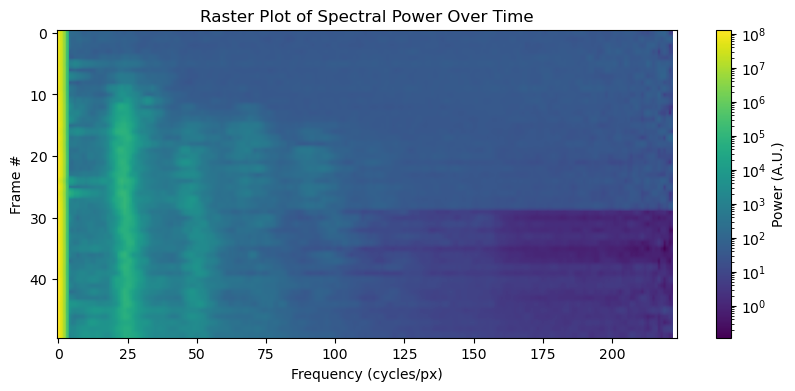

In [157]:
spectra_over_time = batch_compute_2d_psd(data)

# Visualization of the raster plot
plt.figure(figsize=(10, 4))
plt.imshow(spectra_over_time, aspect='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='Power (A.U.)')
plt.xlabel('Frequency (cycles/px)')
plt.ylabel('Frame #')
plt.title('Raster Plot of Spectral Power Over Time')
plt.show()

C:\Users\ariel\AppData\Local\Temp\ipykernel_2216\3063009291.py:23: RuntimeWarning: Mean of empty slice
  mpow = np.nanmean(pol_psd, 0)


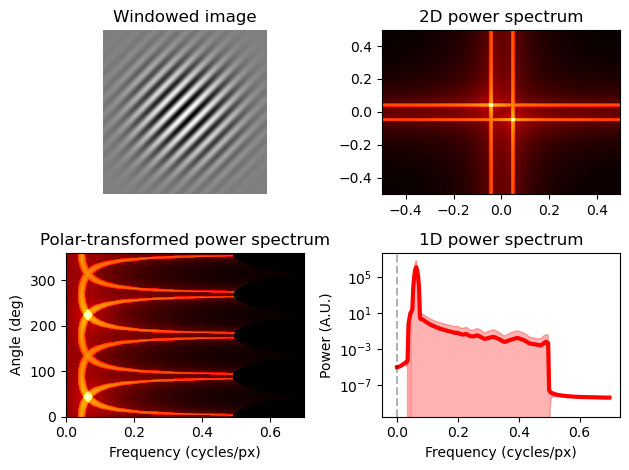

In [162]:
# Create a grid of x and y coordinates
x = np.linspace(-np.pi, np.pi, 224)
y = np.linspace(-np.pi, np.pi, 224)
xv, yv = np.meshgrid(x, y)

f = 10  # Frequency
phi = np.radians(30)  # Phase in radians

# Compute the 2D sine wave with the given frequency and phase
sine_wave = np.sin(f * (xv + yv) + phi)

# Use the 2D sine wave instead of the noise
mpow, stdpow, pos_freq = compute_2d_psd(sine_wave)

C:\Users\ariel\AppData\Local\Temp\ipykernel_2216\3063009291.py:23: RuntimeWarning: Mean of empty slice
  mpow = np.nanmean(pol_psd, 0)


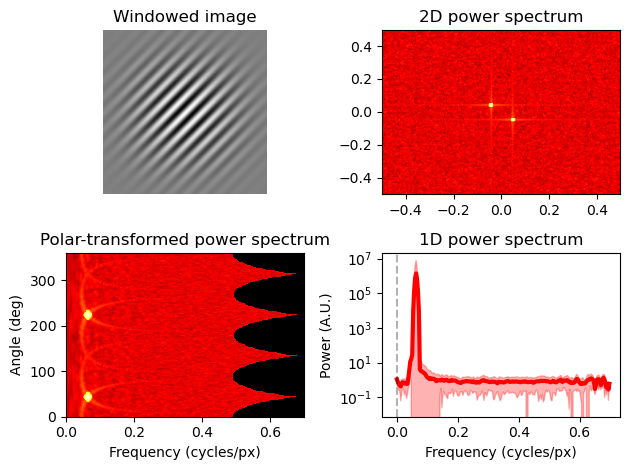

In [169]:
# Create a grid of x and y coordinates
x = np.linspace(-np.pi, np.pi, 224)
y = np.linspace(-np.pi, np.pi, 224)
xv, yv = np.meshgrid(x, y)

# Define the frequency and phase
f = 10  # Frequency
phi = np.radians(60)  # Phase in radians

# Compute the 2D sine wave with the given frequency and phase
sine_wave = np.sin(f * (xv + yv) + phi)

# Generate a noise array with the same shape as the sine wave
noise = np.random.normal(0, 1, sine_wave.shape)

# Define the noise factor
noise_factor = 0.01

# Add the noise to the sine wave
sine_wave_with_noise = sine_wave + noise_factor * noise

# Use the 2D sine wave with noise instead of the noise
mpow, stdpow, pos_freq = compute_2d_psd(sine_wave_with_noise)